In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
                        
import warnings
warnings.filterwarnings("ignore")

# Overview

In this notebook, we are going to explore two binary linear classification models, concretely Logistic Regression (LR) and Linear Discriminant Analysis (LDA). The main goals of this notebook are:

- Learn how to use the plug-and-play models implemented in the Python package sklearn
- Evaluate robustness of both models to data pertubation.
- Explore the power of basis functions for linearly non-separable classes.
- Evaluate our models. Understand which metrics are (not) suitable for imbalance datasets.

# Datasets

We consider two datasets:
- 2-dimensional isotropic Gaussian blobs. The samples for each class are generated from gaussian distribution with certain mean and standard deviation.
- 2-dimensional circles. Samples for each class are generated from circles with a certain radius plus some noise.

In [2]:
from sklearn.datasets import make_circles, make_blobs

In [3]:
def plot_dataset(X, y, title, axes=None):
    if axes is None:
        axes = plt.gca()
    y_zero = y==0
    y_one = y==1
    
    axes.scatter(X[y_zero, 0], X[y_zero, 1], color="red", label="Class 0")
    axes.scatter(X[y_one, 0], X[y_one, 1], color="blue", label="Class 1")
    axes.set_title(title)
    axes.set_xlabel("x1")
    axes.set_ylabel("x2")
    axes.legend()

In [4]:
n_samples = 100
X_blobs, y_blobs = make_blobs(n_samples=n_samples, centers=[(-1, -1), (1, 1)], cluster_std=0.5)
X_circles, y_circles = make_circles(n_samples=n_samples, factor=0.25, noise=0.05)

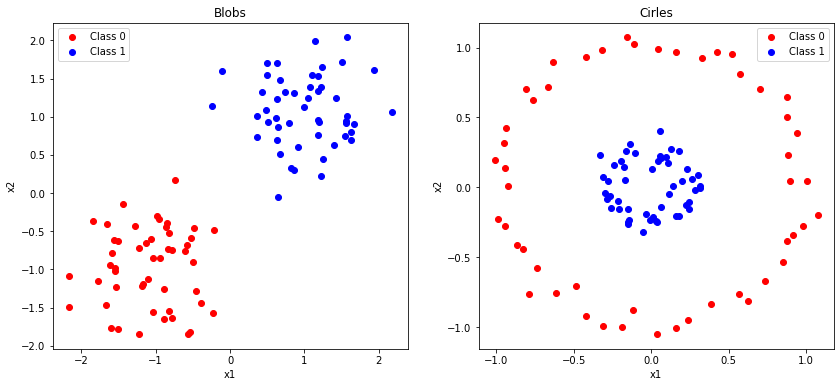

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plot_dataset(X_blobs, y_blobs, title="Blobs", axes=ax[0])
plot_dataset(X_circles, y_circles, title="Cirles", axes=ax[1])

# Binary Linear Classification

Let us assume we have access to $n$ i.i.d training samples $D_n=(x_i, y_i)_{i=1}^n$, with $\mathbf{x}_i \in \mathbb{R}^d$. Throughout this notebook, we are going to focus on the **binary linear classification setting**:

- The **binary** part implies that our output (a.k.a target or label) takes values $y_i=\{-1, +1\}$.
- The **linear** part implies we consider a family of functions $f \in \mathcal{F}$ that are linear, i.e $\mathcal{F} = \big\{\langle \mathbf{w}, \mathbf{x} \rangle +~ b\, \text{with}~\mathbf{x}, \mathbf{w} \in \mathbb{R}^d, b \in \mathbb{R}\big\}$. In particular, we consider the output (prediction) of our classifier is

\begin{align}
\hat{y}(x) = \operatorname{sign}(f(x)) = \operatorname{sign}(\langle \mathbf{w}, \mathbf{x} \rangle +b) = 
\begin{cases}
1, & \text{if} ~\langle \mathbf{w}, \mathbf{x} \rangle +~ b \gt 0 \\
-1, & \text{if} ~\langle \mathbf{w}, \mathbf{x} \rangle +~ b \le 0
\end{cases}
\end{align}

We refer to **decision boundary** of the classifier $\hat{y}(\mathbf{x})=\operatorname{sign}(f(\mathbf{x}))$ to the set of points in the input spaces such that the output of $f(\mathbf{x})$ is zero, i.e $\{\mathbf{x} \in \mathcal{X} \mid f(\mathbf{x})=0\}$. 
Basically, the decision boundary separates the input space $\mathbb{R}^d$ into two half spaces.

**Remark**. As with linear regression, we could also apply basis functions to map the input features $\mathbf{x}_i \in \mathbb{R}^d$ into a possibly larger feature space $\mathbb{R}^D$, i.e $\mathbf{x} \in \mathbb{R}^d \rightarrow (\phi_1(\mathbf{x}), ..., \phi_D(\mathbf{x}))$


## Logistic Regression (LR)

Logistic regression is a supervised algorithm that models the conditional likelihood $p(y|\mathbf{x})$ using a sigmoid function.
\begin{align}
p = \operatorname{P}(Y=1 \mid X=\mathbf{x}, \mathbf{w}, b) = \frac{1}{1+e^{-\langle\mathbf{w},\phi(\mathbf{x})\rangle + b}}, \tag{1}
\end{align}
and finds the model parameters using Maximum Likelihood Estimation (MLE):
\begin{align}
\mathbf{w}^* &= \underset{\mathbf{w}}{\operatorname{\arg \max}} \prod_{i=1}^n \operatorname{P}(Y=y_i \mid X=\mathbf{x}_i, \mathbf{w}) \tag{2}\\
& = \underset{\mathbf{w}}{\operatorname{\arg \max}} \sum_{i=1}^n \operatorname{log} \operatorname{P}(Y=y_i \mid X=\mathbf{x}_i, \mathbf{w}) \tag{3}\\
& = \underset{\mathbf{w}}{\operatorname{\arg \min}} \sum_{i=1}^n \operatorname{log} \big( 1+e^{-\langle\mathbf{w},\phi(\mathbf{x})\rangle} \big) \tag{4}
\end{align}

## Linear Discriminant Analysis (LDA)

Linear Discriminant Analysis is a supervised algorithm that assumes our data $\mathbf{x}$ comes from an isotropic Gaussian distribution. LDA models the distribution $p(\mathbf{x}|y)$. Then, it tries to find the linear projection $\mathbf{w}$ that (i) maximizes the distance between the means of the two classes, and (ii) minimizes the variance within each class. It does so by maximizing the Fisher criterion:

\begin{align}
\mathbf{w}^* = \underset{\mathbf{w}}{\arg \max} J(\mathbf{w}) = \underset{\mathbf{w}}{\arg \max} \frac{\langle \mathbf{w}, m_+ - m_- \rangle ^2}{\sigma^2_{\mathbf{w}, +} + \sigma^2_{\mathbf{w}, -}}
\end{align}

To maximize the Fisher criterion we need to:
1. Compute the $d$-dimensional class centroid (a.k.a means):
\begin{align}
m_+ = \frac{1}{n_+} \underset{\{i \mid Y_i = 1\}}{\sum} X_i, ~ m_- = \frac{1}{n_-} \underset{\{i \mid Y_i = -1\}}{\sum} X_i
\end{align}

2. Compute the within-class covariance of the projections of the positive and negative class:
\begin{align}
\sigma^2_{\mathbf{w}, +} = \underset{\{i \mid Y_i = 1\}}{\sum} (\langle \mathbf{w}, X_i \rangle - \langle \mathbf{w}, m_+ \rangle)^2 ~ \sigma^2_{\mathbf{w}, -} = \underset{\{i \mid Y_i = -1\}}{\sum} (\langle \mathbf{w}, X_i \rangle - \langle \mathbf{w}, m_- \rangle)^2
\end{align}

## Performace Metrics

In order to determine the quality of a classifier $\hat{y}: \mathcal{X} \rightarrow \{-1, 1\}$ on a dataset $D_n=(x_i, y_i)^n_{i=1}$, the following metrics are commonly used.
\begin{align}
TP = \sum_{i=1}^n \mathbb{1}_{\hat{y}(x_i)=1 ~\wedge~ y_i=1} && FN = \sum_{i=1}^n \mathbb{1}_{\hat{y}(x_i)=-1 ~\wedge~ y_i=1} \tag{5} \\
FP = \sum_{i=1}^n \mathbb{1}_{\hat{y}(x_i)=1 ~\wedge~ y_i=-1} && TN = \sum_{i=1}^n \mathbb{1}_{\hat{y}(x_i)=-1 ~\wedge~ y_i=-1} \tag{6} 
\end{align}

**Accuracy** measures the percentage of observations that are correctly classified.
\begin{align}
Accuracy = \frac{TP+TN}{TP+TN+FP+FN} = \frac{1}{n}\sum_{i=1}^n \mathbb{1}_{f(x_i)=y_i}
\end{align}

**Precision** measures how many predictions out of all positive predictions (i.e TP+FP) are positive observations.
$$Precision = \frac{TP}{TP+FP}$$

**Recall** measures how many observations out of all positive observations (i.e TP+FN) have we classified as positive.
$$Recall = \frac{TP}{TP+FN}$$

**False Positive Rate (FPR)** measures how many observations out of all the negative observations (i.e N=FP+TN) have we classified as positive.
$$FPR = \frac{FP}{FP+TN}$$

**F1-Score** is the harmonic mean of Precision + Recall. It combines the two measures into one. Why don't we just use the mean? Well, it's simply because the harmonic mean punishes the extreme values.
$$F1\text{-}Score = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$$

**ROC curve** plots the Recall versus the false positive rate (FPR) by varying the discrimination threshold $\theta \in [0, 1]$.

**PR curve** plots the precision (PPV) versus the recall (TPR) by varying the dicrimination threshold $\theta \in [0,1]$.


## Robustness to data perturbations

Analyze how the decision boundaries of the two algorithms under study change when we add a second Gaussian blob.

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## Decision Boundary LDA

The decision boundry for LDA is given by
$$\{x \in \mathbb{R}^d \mid \langle \mathbf{w}, \mathbf{x} \rangle + b = 0 \}$$
In order to determine a point on the decision boundry we can fix the first $d$-1 coordinates for $x \in \mathbb{R}^d$ and then solve for $x_d$.

\begin{align}
&\langle \mathbf{w}, \mathbf{x} \rangle + b = 0 \tag{7} \\
&\Leftrightarrow \sum_{i=1}^d w_i x_i + b = 0 \tag{8} \\
&\Leftrightarrow \sum_{i=1}^{d-1} w_i x_i + (w_d x_d) + b  = 0 \\
&\Leftrightarrow x_d  = -\frac{\sum_{i=1}^{d-1} w_i x_i + b}{w_d} \tag{9}
\end{align}

## Decision Boundary of Logistic Regression

The decision boundary for the logistic regression are all points which satisty the following equation:
$$p = \operatorname{P}(Y=1 \mid X=\mathbf{x}, \mathbf{w}) = \frac{1}{1+e^{-(\langle \mathbf{w}, \mathbf{x} \rangle + b)}} = \frac{1}{2}\tag{10}$$ 

This is equivalent to:
$$e^{-(\langle \mathbf{w}, \mathbf{x} \rangle + b)} = 1$$

Applying $ln$ on both sides and multiplying by $-1$ yields:
$$\langle \mathbf{w}, \mathbf{x} \rangle + b = 0$$

Now, we can proceed exactly as for the LDA.

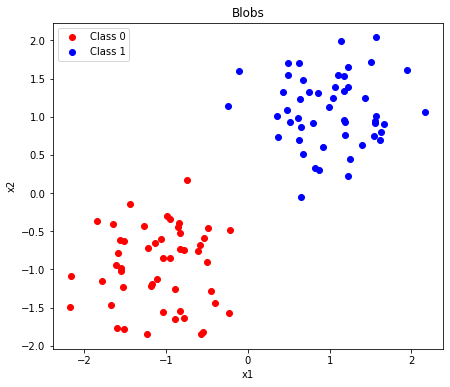

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
plot_dataset(X_blobs, y_blobs, title="Blobs", axes=ax)

In [8]:
def compute_lda_decision_boundry(coef, intercept, x1, x2):
    w1, w2 = coef
    y1 = (-intercept - w1*x1) / w2
    y2 = (-intercept - w1*x2) / w2
    return [[x1, x2], [y1, y2]]

def compute_lr_decision_boundry(coef, intercept, x1, x2):
    w1, w2 = coef
    y1 = - (w1/w2)*x1 - intercept/w2
    y2 = - (w1/w2)*x2 - intercept/w2
    return [[x1, x2], [y1, y2]]

Accuracy LDA = 1.00
Accuracy LR = 1.00


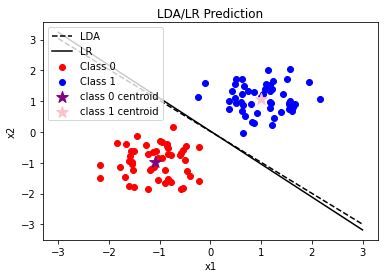

In [9]:
lda = LinearDiscriminantAnalysis().fit(X_blobs, y_blobs)
lda_pred = lda.predict(X_blobs)
print(f"Accuracy LDA = {accuracy_score(y_blobs, lda_pred):.2f}")

logistic_regression = LogisticRegression().fit(X_blobs, y_blobs)
logistic_regression_pred = logistic_regression.predict(X_blobs)
print(f"Accuracy LR = {accuracy_score(y_blobs, logistic_regression_pred):.2f}")

fig, axes = plt.subplots(1, 1, figsize=(6, 4))
axes.plot(*compute_lda_decision_boundry(lda.coef_[0], lda.intercept_, -3, 3), color="black", linestyle="dashed", label="LDA")
axes.plot(*compute_lr_decision_boundry(logistic_regression.coef_[0], logistic_regression.intercept_, -3, 3), color="black", label="LR")
plot_dataset(X_blobs, lda_pred, title="LDA/LR Prediction", axes=axes)
plt.scatter(*X_blobs[y_blobs==0].mean(0), color="purple", marker="*", s=150, label="class 0 centroid")
plt.scatter(*X_blobs[y_blobs==1].mean(0), color="pink", marker="*", s=150, label="class 1 centroid")
plt.legend();

In [10]:
print(f"class centroids={X_blobs[y_blobs==0].mean(0)} {X_blobs[y_blobs==1].mean(0)}")

class centroids=[-1.08970818 -0.96225302] [1.00498669 1.08351741]


In [11]:
print("Logisitc Regression")
print(f"[w0, w1]={logistic_regression.coef_[0]}")
print(f"b={logistic_regression.intercept_[0]}")
print("\nLinear Discriminant Analysis")
print(f"[w0, w1]={lda.coef_[0]}")
print(f"b={lda.intercept_[0]}")
print(f"class centroids={lda.means_[0]}{lda.means_[1]}")

Logisitc Regression
[w0, w1]=[2.12248429 1.98385535]
b=-0.05556785044693429

Linear Discriminant Analysis
[w0, w1]=[8.5536597  8.51009445]
b=-0.15364630916568878
class centroids=[-1.08970818 -0.96225302][1.00498669 1.08351741]


Now, we will add a second blob to the positive class. How do the decision boundaries change? Which algorithm is more robust to outliers?

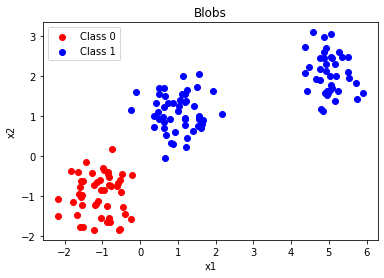

In [12]:
mean = [5, 2]
cov = [[0.2, 0], [0, 0.2]]
num = 40
outlier = np.random.multivariate_normal(mean, cov, num)

X_blobs_outlier = np.concatenate((X_blobs, outlier))
y_blobs_outlier = np.concatenate((y_blobs, np.ones(outlier.shape[0])))
plot_dataset(X_blobs_outlier, y_blobs_outlier, title="Blobs")

In [13]:
lda = LinearDiscriminantAnalysis().fit(X_blobs_outlier, y_blobs_outlier)
lda_pred = lda.predict(X_blobs_outlier)
print(f"Accuracy LDA = {accuracy_score(y_blobs_outlier, lda_pred):.2f}")

logistic_regression = LogisticRegression().fit(X_blobs_outlier, y_blobs_outlier)
logistic_regression_pred = logistic_regression.predict(X_blobs_outlier)
print(f"Accuracy LR = {accuracy_score(y_blobs_outlier, logistic_regression_pred):.2f}")

Accuracy LDA = 0.99
Accuracy LR = 1.00


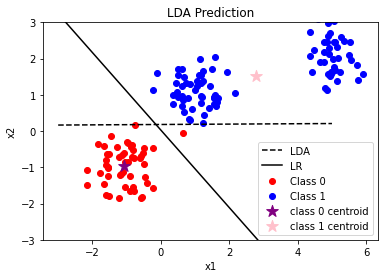

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
axes.set_ylim(-3, 3)
axes.plot(*compute_lda_decision_boundry(lda.coef_[0], lda.intercept_, -3, 5), color="black", linestyle="dashed", label="LDA")
axes.plot(*compute_lr_decision_boundry(logistic_regression.coef_[0], logistic_regression.intercept_, -3, 3), color="black", linestyle="solid", label="LR")
plot_dataset(X_blobs_outlier, lda_pred, title="LDA Prediction", axes=axes)
plt.scatter(*X_blobs_outlier[y_blobs_outlier==0].mean(0), color="purple", marker="*", s=150, label="class 0 centroid")
plt.scatter(*X_blobs_outlier[y_blobs_outlier==1].mean(0), color="pink", marker="*", s=150, label="class 1 centroid")
plt.legend();


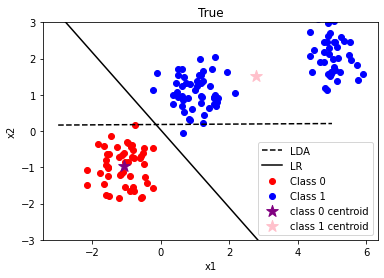

In [15]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
axes.set_ylim(-3, 3)
axes.plot(*compute_lda_decision_boundry(lda.coef_[0], lda.intercept_, -3, 5), color="black", linestyle="dashed", label="LDA")
axes.plot(*compute_lr_decision_boundry(logistic_regression.coef_[0], logistic_regression.intercept_, -3, 3), color="black", linestyle="solid", label="LR")
plot_dataset(X_blobs_outlier, y_blobs_outlier, title="True", axes=axes)
plt.scatter(*X_blobs_outlier[y_blobs_outlier==0].mean(0), color="purple", marker="*", s=150, label="class 0 centroid")
plt.scatter(*X_blobs_outlier[y_blobs_outlier==1].mean(0), color="pink", marker="*", s=150, label="class 1 centroid")
plt.legend();


In [16]:
print("Logisitc Regression")
print(f"[w0, w1]={logistic_regression.coef_[0]}")
print(f"b={logistic_regression.intercept_[0]}")
print("\nLinear Discriminant Analysis")
print(f"[w0, w1]={lda.coef_[0]}")
print(f"b={lda.intercept_[0]}")
print(f"class centroids={lda.means_[0]}{lda.means_[1]}")

Logisitc Regression
[w0, w1]=[2.12255855 1.98387268]
b=-0.055519101160779134

Linear Discriminant Analysis
[w0, w1]=[-0.0329519   6.30446502]
b=-1.1474848630344496
class centroids=[-1.08970818 -0.96225302][2.78853859 1.52162209]


**Question** Looking at the decision boundary obtained, What is happening in the LDA optimization?
> a) LDA maximizes the distance between the means of the two classes

> b) LDA minimizes the variance within each class

From now on, we will focus on the Logistic Regression classifier

## Introducing basis functions

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

First, we fit a Logistic Regression model on vanilla linear features.

Accuracy=0.51


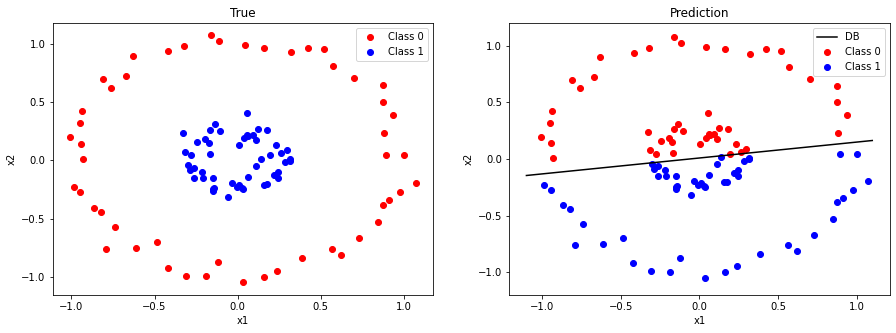

In [18]:
logistic_regression = LogisticRegression().fit(X_circles, y_circles)
logistic_regression_pred = logistic_regression.predict(X_circles)
print(f"Accuracy={accuracy_score(y_circles, logistic_regression_pred):.2f}")

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_dataset(X_circles, y_circles, title="True", axes=ax[0])
ax[1].plot(*compute_lr_decision_boundry(logistic_regression.coef_[0], logistic_regression.intercept_, -1.1, 1.1), color="black", label="DB")
ax[1].set_ylim(-1.2, 1.2)
plot_dataset(X_circles, logistic_regression_pred, title="Prediction", axes=ax[1])

Clearly, the data is not linearly seperable. Now, there are two possibilities to tackle this problem. One could use a non-linear classifier that has sufficient capacity to model such a decision boundary, or one could transform the data such that it becomes linearly seperable. This is also the approach presented in the following:

We use the transformation:
$$\phi: \mathbb{R}^2 \rightarrow \mathbb{R}^3, (x_1, x_2)^T \mapsto (x_1, x_2, x_1^2+x_2^2)^T$$

X shape: (100, 2)
X_transformed shape: (100, 3)


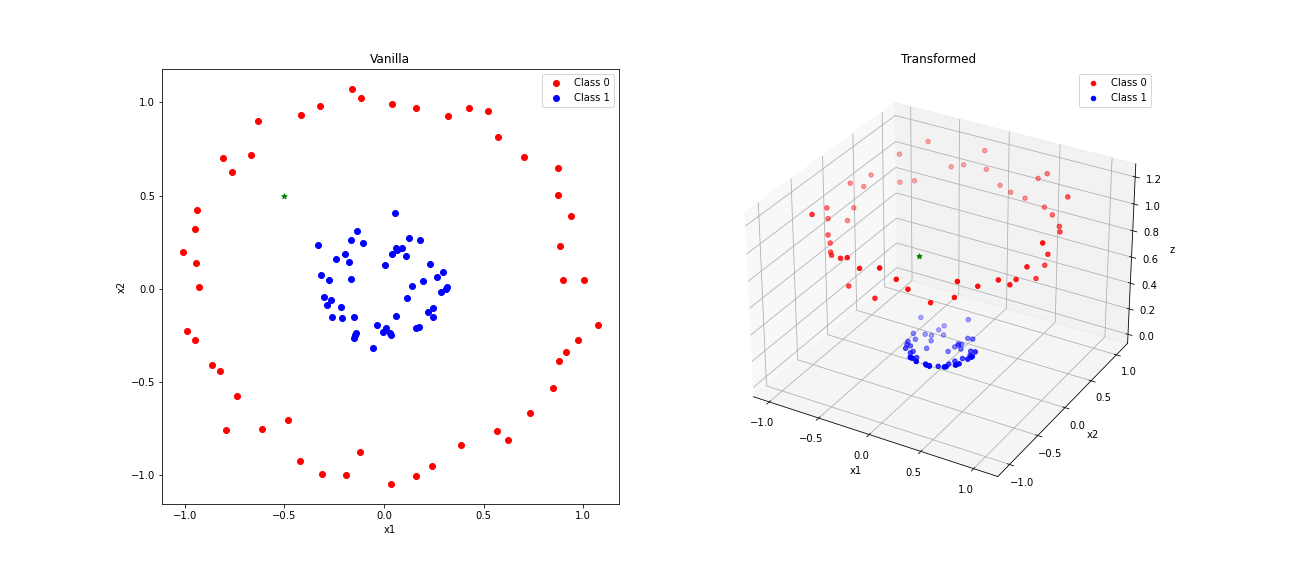

In [19]:
from mpl_toolkits.mplot3d import Axes3D

# Enabling the `widget` backend.
# This requires jupyter-matplotlib aka ipympl
# ipympl can be installed via pip or conda
%matplotlib widget

t = lambda x1, x2: (np.square(x1) + np.square(x2)).reshape(-1, 1)
X_t = t(X_circles[:, 0], X_circles[:, 1])
X_transformed = np.concatenate((X_circles, X_t), axis=1)
print(f"X shape: {X_circles.shape}")
print(f"X_transformed shape: {X_transformed.shape}")

red = y_circles == 0
blue = y_circles == 1

fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection="3d")

plot_dataset(X_circles, y_circles, title="Vanilla", axes=ax1)
ax1.scatter(-0.5, 0.5, color="green", marker="*", s=30)

ax2.scatter3D(X_transformed[red, 0], X_transformed[red, 1], X_transformed[red, 2], color="red", label="Class 0")
ax2.scatter3D(X_transformed[blue, 0], X_transformed[blue, 1], X_transformed[blue, 2], color="blue", label="Class 1")
ax2.scatter3D(-0.5, 0.5, t(-0.5,0.5), color="green", marker="*", s=30)

ax2.set_xlabel("x1")
ax2.set_ylabel("x2")
ax2.set_zlabel("z")
ax2.set_title("Transformed")
ax2.legend()
plt.show()

As as next, we fit a LR model on the transformed data and plot the decision surface.

Accuracy on vanilla data: 0.51
Accuracy on transformed data: 1.00


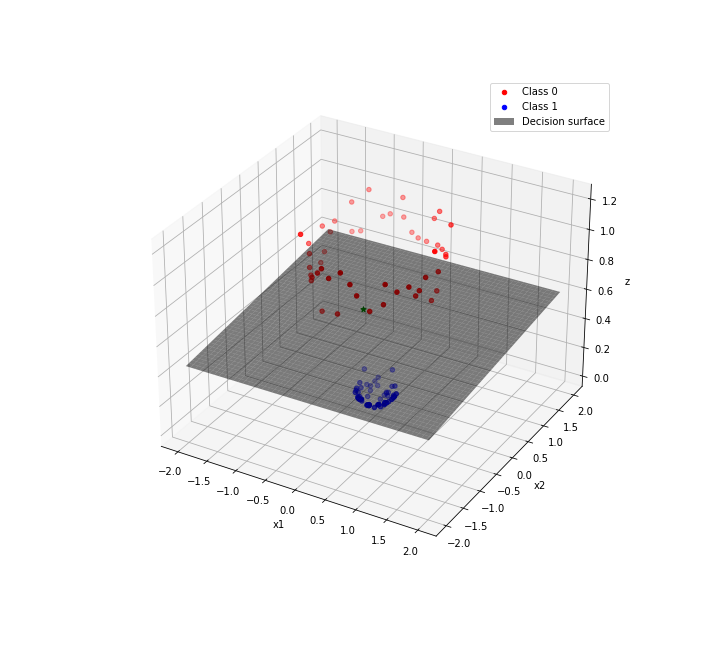

In [20]:
logistic_regression_t = LogisticRegression().fit(X_transformed, y_circles)
logistic_regression_t_pred = logistic_regression_t.predict(X_transformed)
x = np.linspace(-2, 2, 100)
x1, x2 = np.meshgrid(x, x)

w1, w2, w3 = logistic_regression_t.coef_[0]
b = logistic_regression_t.intercept_

z = - (w2/w3)*x2 - (w1/w3)*x1 - b/w3

fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(projection="3d")
red = y_circles == 0
blue = y_circles == 1

ax.scatter(X_transformed[red, 0], X_transformed[red, 1], X_transformed[red, 2], color="red", label="Class 0")
ax.scatter(X_transformed[blue, 0], X_transformed[blue, 1], X_transformed[blue, 2], color="blue", label="Class 1")
ax.scatter(-0.5, 0.5, t(-0.5,0.5), color="green", marker="*", s=30)

surf = ax.plot_surface(x1, x2, z, alpha=0.5, color="black", label="Decision surface")
surf._facecolors2d = surf._facecolor3d # https://stackoverflow.com/questions/54994600/pyplot-legend-poly3dcollection-object-has-no-attribute-edgecolors2d
surf._edgecolors2d = surf._edgecolor3d
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("z")
print(f"Accuracy on vanilla data: {accuracy_score(y_circles, logistic_regression_pred):.2f}")
print(f"Accuracy on transformed data: {accuracy_score(y_circles, logistic_regression_t_pred):.2f}")
ax.legend()
plt.show()

In [21]:
logistic_regression_t.predict(np.array([[-0.5, 0.5, t(-0.5, 0.5)]]))

array([1])

## Exploring evaluation metrics

In the following, we are going to explore different evaluation metrics

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_roc_curve, plot_confusion_matrix, plot_precision_recall_curve, accuracy_score, f1_score

In [23]:
mean = [-1, 0]
cov = [[0.3, 0], [0, 0.3]]
num = 20
outlier = np.random.multivariate_normal(mean, cov, num)

X_blobs_2 = np.concatenate((X_blobs, outlier))
y_blobs_2 = np.concatenate((y_blobs, np.ones(outlier.shape[0])))

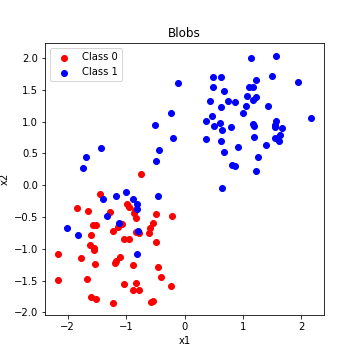

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_dataset(X_blobs_2, y_blobs_2, title="Blobs", axes=ax)

Accuracy=0.91


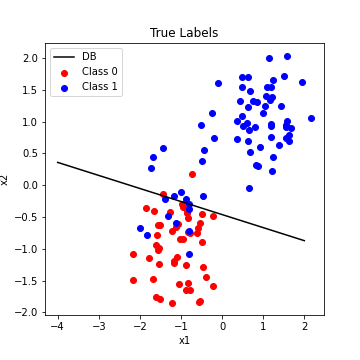

In [25]:
logistic_regression = LogisticRegression().fit(X_blobs_2, y_blobs_2)
logistic_regression_pred = logistic_regression.predict(X_blobs_2)

print(f"Accuracy={accuracy_score(y_blobs_2, logistic_regression_pred):.2f}")
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(*compute_lr_decision_boundry(logistic_regression.coef_[0], logistic_regression.intercept_, -4, 2), color="black", label="DB")
plot_dataset(X_blobs_2, y_blobs_2, title="True Labels", axes=ax)


Compare precision/recall/accuracy/F1 score

In [26]:
print(f1_score(y_blobs_2, logistic_regression_pred))

0.9172932330827068


In [27]:
print(classification_report(y_blobs_2, logistic_regression_pred, target_names=["Class 0", "Class 1"]))

              precision    recall  f1-score   support

     Class 0       0.84      0.96      0.90        50
     Class 1       0.97      0.87      0.92        70

    accuracy                           0.91       120
   macro avg       0.91      0.92      0.91       120
weighted avg       0.92      0.91      0.91       120



Plot confusion matrix

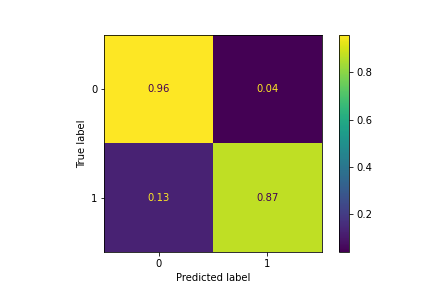

In [28]:
plot_confusion_matrix(logistic_regression, X_blobs_2, y_blobs_2, labels=[0, 1], normalize="true");

ROC curve

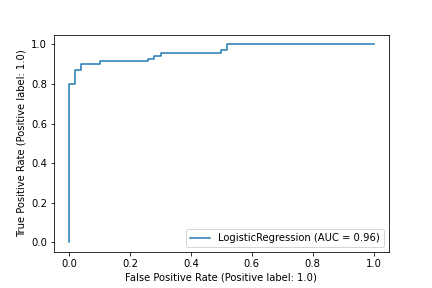

In [29]:
plot_roc_curve(logistic_regression, X_blobs_2, y_blobs_2);

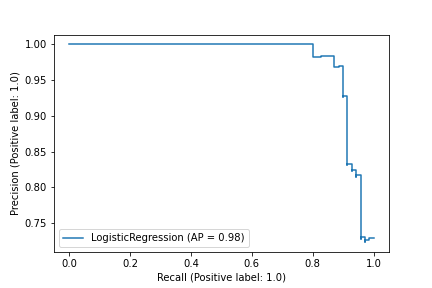

In [30]:
plot_precision_recall_curve(logistic_regression, X_blobs_2, y_blobs_2);

## Binary classification: Unbalanced classes

- Plot the decision boundaries of LR when training with a dataset without basis function with non Linear separable dataset.
- Compare precision/recall/accuracy/F1 score (use https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
- Plot confusion matrix
- ROC curve
- PR curve

In [31]:
# make imbalanced blobs
def make_imbalanced_blobs(n_samples):
    X1, y1 = make_blobs(n_samples=2*n_samples[0], centers=[(-1, -1), (1, 1)], cluster_std=1.5)
    X2, y2 = make_blobs(n_samples=2*n_samples[1], centers=[(-1, -1), (1, 1)], cluster_std=1.5)
    return np.concatenate((X1[y1==0], X2[y2==1])), np.concatenate((y1[y1==0], y2[y2==1]))

Accuracy=0.84


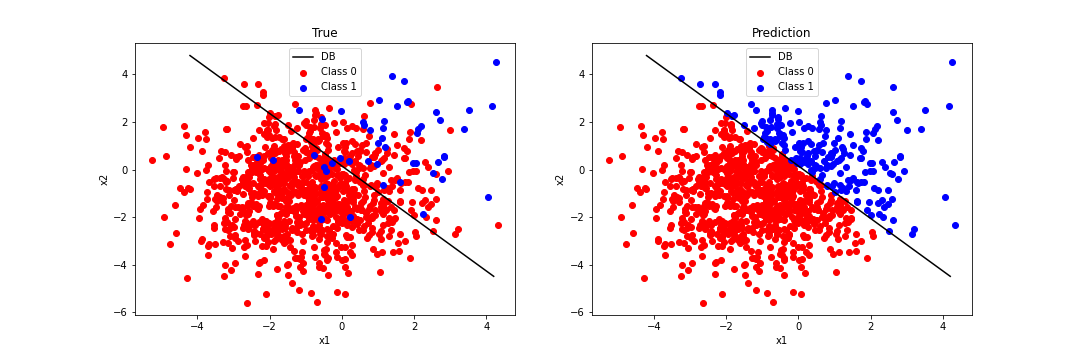

In [32]:
X_blobs_imbalanced, y_blobs_imbalanced = make_imbalanced_blobs([1000, 50])
logistic_regression = LogisticRegression(class_weight={0:1, 1:20}).fit(X_blobs_imbalanced, y_blobs_imbalanced)

logistic_regression_pred = logistic_regression.predict(X_blobs_imbalanced)
print(f"Accuracy={accuracy_score(y_blobs_imbalanced, logistic_regression_pred):.2f}")

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(*compute_lr_decision_boundry(logistic_regression.coef_[0], logistic_regression.intercept_, -4.2, 4.2), color="black", label="DB")
plot_dataset(X_blobs_imbalanced, y_blobs_imbalanced, title="True", axes=ax[0])

ax[1].plot(*compute_lr_decision_boundry(logistic_regression.coef_[0], logistic_regression.intercept_, -4.2, 4.2), color="black", label="DB")
plot_dataset(X_blobs_imbalanced, logistic_regression_pred, title="Prediction", axes=ax[1])

In [33]:
print(f1_score(y_blobs_imbalanced, logistic_regression_pred))

0.3228346456692913


In [34]:
print(classification_report(y_blobs_imbalanced, logistic_regression_pred, target_names=["Class 0", "Class 1"]));

              precision    recall  f1-score   support

     Class 0       0.99      0.84      0.91      1000
     Class 1       0.20      0.82      0.32        50

    accuracy                           0.84      1050
   macro avg       0.60      0.83      0.61      1050
weighted avg       0.95      0.84      0.88      1050



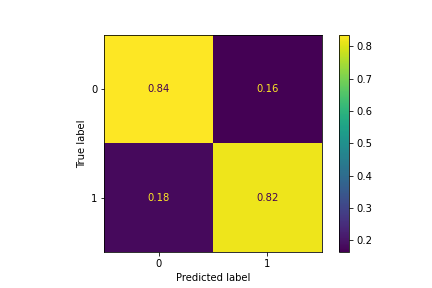

In [35]:
plot_confusion_matrix(logistic_regression, X_blobs_imbalanced, y_blobs_imbalanced, labels=[0, 1], normalize="true");

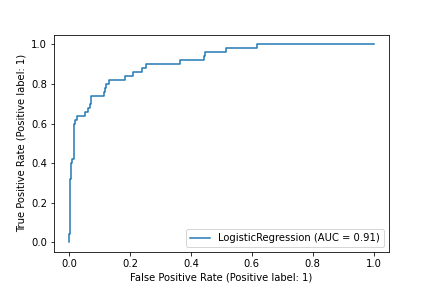

In [36]:
plot_roc_curve(logistic_regression, X_blobs_imbalanced, y_blobs_imbalanced);

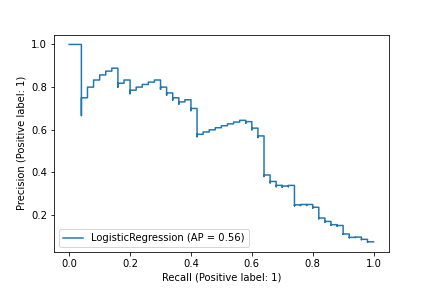

In [37]:
plot_precision_recall_curve(logistic_regression, X_blobs_imbalanced, y_blobs_imbalanced);

### Sources
- https://scikit-learn.org/stable/modules/lda_qda.html#lda-qda-math
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

### Credit
This notebook was created by UdS ML21 tutors and modified by ML22 team. Thanks to Pablo Sanchez Martin and team.